In [1]:
import mmcv
from mmdet3d.apis import init_model, inference_detector
import open3d as o3d
import numpy as np
from math import cos, sin
import torch

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
# Step 1: Set the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# Step 2: Define paths for the config and checkpoint files
config_file = './configs/pv_rcnn/pv_rcnn_8xb2-80e_kitti-3d-3class.py'
checkpoint_file = './checkpoints/pv_rcnn_8xb2-80e_kitti-3d-3class_20221117_234428-b384d22f.pth'

In [7]:
# Step 3: Initialize the model
model = init_model(config_file, checkpoint_file, device=device)

c:\Users\PC DE FERI\mmdetection3d\mmdet3d\models\dense_heads\anchor3d_head.py:94: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(


Loads checkpoint by local backend from path: ./checkpoints/pv_rcnn_8xb2-80e_kitti-3d-3class_20221117_234428-b384d22f.pth


In [8]:
# Step 4: Load the LiDAR point cloud sample from .pcd file
# Replace with your actual .pcd file path
pcd_file = './data/Robotshuttle/1725985788.120221615.pcd'

In [9]:
# Step 5: Load and visualize the point cloud using Open3D
def load_pcd_file(pcd_file):
    # Load the point cloud from .pcd file using Open3D
    pcd = o3d.io.read_point_cloud(pcd_file)
    point_cloud = np.asarray(pcd.points)  # Convert to numpy array

    # The point cloud needs to have shape (N, 4) where the 4th dimension can be zeros (if intensity data is missing)
    if isinstance(point_cloud, np.ndarray):
        if point_cloud.shape[1] == 3:  # Check if it's (N, 3)
            # Add intensity (or a dummy column of zeros)
            point_cloud = np.hstack(
                [point_cloud, np.zeros((point_cloud.shape[0], 1))])
        return point_cloud
    else:
        raise ValueError("Loaded point cloud is not in the correct format")


# Usage
points = load_pcd_file(pcd_file)

# Ensure points is a numpy array with the correct shape
if not isinstance(points, np.ndarray):
    raise TypeError("Points must be a numpy array")

# Now you can safely use points.shape[1] in the rest of your code


# Load the point cloud from the .pcd file
point_cloud = load_pcd_file(pcd_file)

# Convert to Open3D point cloud format
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(point_cloud[:, :3])  # Only use x, y, z

# Convert the point cloud data into a format suitable for inference
# Explicitly move to GPU
points_tensor = torch.tensor(point_cloud, dtype=torch.float32).to(device)
data = {'points': [points_tensor]}

In [10]:
# Step 6: Perform inference (object detection)
result, data = inference_detector(model, points)
print(result)  # Check if there are any predictions

c:\Users\PC DE FERI\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


<Det3DDataSample(

    META INFORMATION
    axis_align_matrix: array([[1., 0., 0., 0.],
               [0., 1., 0., 0.],
               [0., 0., 1., 0.],
               [0., 0., 0., 1.]])
    pcd_vertical_flip: False
    box_type_3d: <class 'mmdet3d.structures.bbox_3d.lidar_box3d.LiDARInstance3DBoxes'>
    pcd_scale_factor: 1.0
    pcd_horizontal_flip: False
    pcd_rotation: tensor([[1., 0., 0.],
                [-0., 1., 0.],
                [0., 0., 1.]])
    transformation_3d_flow: ['R', 'S', 'T']
    box_mode_3d: <Box3DMode.LIDAR: 0>
    pcd_rotation_angle: 0.0
    pcd_trans: array([0., 0., 0.])
    flip: False

    DATA FIELDS
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
        ) at 0x206a039d910>
    eval_ann_info: None
    gt_pts_seg: <PointData(
        
            META INFORMATION
        
            DATA FIELDS
        ) at 0x206a03a77f0>
    gt_instances_3d: <InstanceData(
        
            META INFORMATION


In [11]:
# Step 7: Process and display the detected objects
# Classes for the dataset (e.g., Car, Pedestrian, Cyclist)
class_names = model.dataset_meta['classes']
threshold = 0.5  # Confidence threshold for displaying the detected objects

print(f"Detected objects in {pcd_file}:")
print(class_names)  # Should output the classes the model was trained on
# Helper function to compute the 8 corners of a bounding box


def compute_bounding_box_corners(bbox):
    bbox = bbox.tensor.cpu().numpy()  # Convert to numpy array

    all_corners = []
    for box in bbox:
        x, y, z, dx, dy, dz, heading = box

        rot_matrix = np.array(
            [[cos(heading), -sin(heading)], [sin(heading), cos(heading)]])

        corners = np.array([
            [-dx / 2, -dy / 2, -dz / 2], [dx / 2, -dy / 2, -dz / 2],
            [dx / 2, dy / 2, -dz / 2], [-dx / 2, dy / 2, -dz / 2],
            [-dx / 2, -dy / 2, dz / 2], [dx / 2, -dy / 2, dz / 2],
            [dx / 2, dy / 2, dz / 2], [-dx / 2, dy / 2, dz / 2]
        ])

        rotated_corners = np.dot(corners[:, [0, 1]], rot_matrix)
        corners[:, 0:2] = rotated_corners

        corners[:, 0] += x
        corners[:, 1] += y
        corners[:, 2] += z

        all_corners.append(corners)

    return all_corners

# Helper function to create a 3D bounding box in Open3D


def create_bounding_box_lines(bbox):
    all_bbox_corners = compute_bounding_box_corners(bbox)

    line_sets = []
    for bbox_corners in all_bbox_corners:
        edges = [
            [0, 1], [1, 2], [2, 3], [3, 0],  # Bottom face
            [4, 5], [5, 6], [6, 7], [7, 4],  # Top face
            [0, 4], [1, 5], [2, 6], [3, 7]   # Vertical edges
        ]

        line_set = o3d.geometry.LineSet()
        line_set.points = o3d.utility.Vector3dVector(bbox_corners)
        line_set.lines = o3d.utility.Vector2iVector(edges)
        line_set.colors = o3d.utility.Vector3dVector(
            [[0, 0, 1] for _ in range(len(edges))])

        line_sets.append(line_set)

    return line_sets


# Prepare bounding boxes for visualization
bounding_boxes = []
pred_instances = result.pred_instances_3d
for i in range(len(pred_instances.bboxes_3d)):
    bbox = pred_instances.bboxes_3d[i]  # Get the bounding box tensor
    score = pred_instances.scores_3d[i].cpu().numpy()  # Get confidence score
    label = pred_instances.labels_3d[i].cpu().numpy()  # Get class label

    class_name = class_names[label]
    print(f"Detected {class_name} with confidence {score}")
    bounding_box_lines = create_bounding_box_lines(bbox)
    bounding_boxes.extend(bounding_box_lines)
print(f"Number of detected objects: {len(pred_instances.bboxes_3d)}")

Detected objects in ./data/Robotshuttle/1725985788.120221615.pcd:
['Pedestrian', 'Cyclist', 'Car']
Detected Car with confidence 0.6632527112960815
Detected Car with confidence 0.5560871958732605
Detected Car with confidence 0.3557191789150238
Detected Car with confidence 0.350493848323822
Detected Car with confidence 0.3145890533924103
Detected Car with confidence 0.25226548314094543
Detected Car with confidence 0.1648983359336853
Number of detected objects: 7


In [ ]:
# Step 8: Visualize the point cloud with bounding boxes using Open3D
vis = o3d.visualization.Visualizer()
vis.create_window()
vis.add_geometry(pcd)

# Add all bounding boxes to the visualizer
for bbox in bounding_boxes:
    vis.add_geometry(bbox)

# Non-blocking visualization
while True:
    vis.poll_events()
    vis.update_renderer()

![Captura de pantalla 2024-10-20 222405.png](<attachment:Captura de pantalla 2024-10-20 222405.png>)
![Captura de pantalla 2024-10-20 222431.png](<attachment:Captura de pantalla 2024-10-20 222431.png>)
![Captura de pantalla 2024-10-20 222555.png](<attachment:Captura de pantalla 2024-10-20 222555.png>)
![Captura de pantalla 2024-10-20 222839.png](<attachment:Captura de pantalla 2024-10-20 222839.png>)

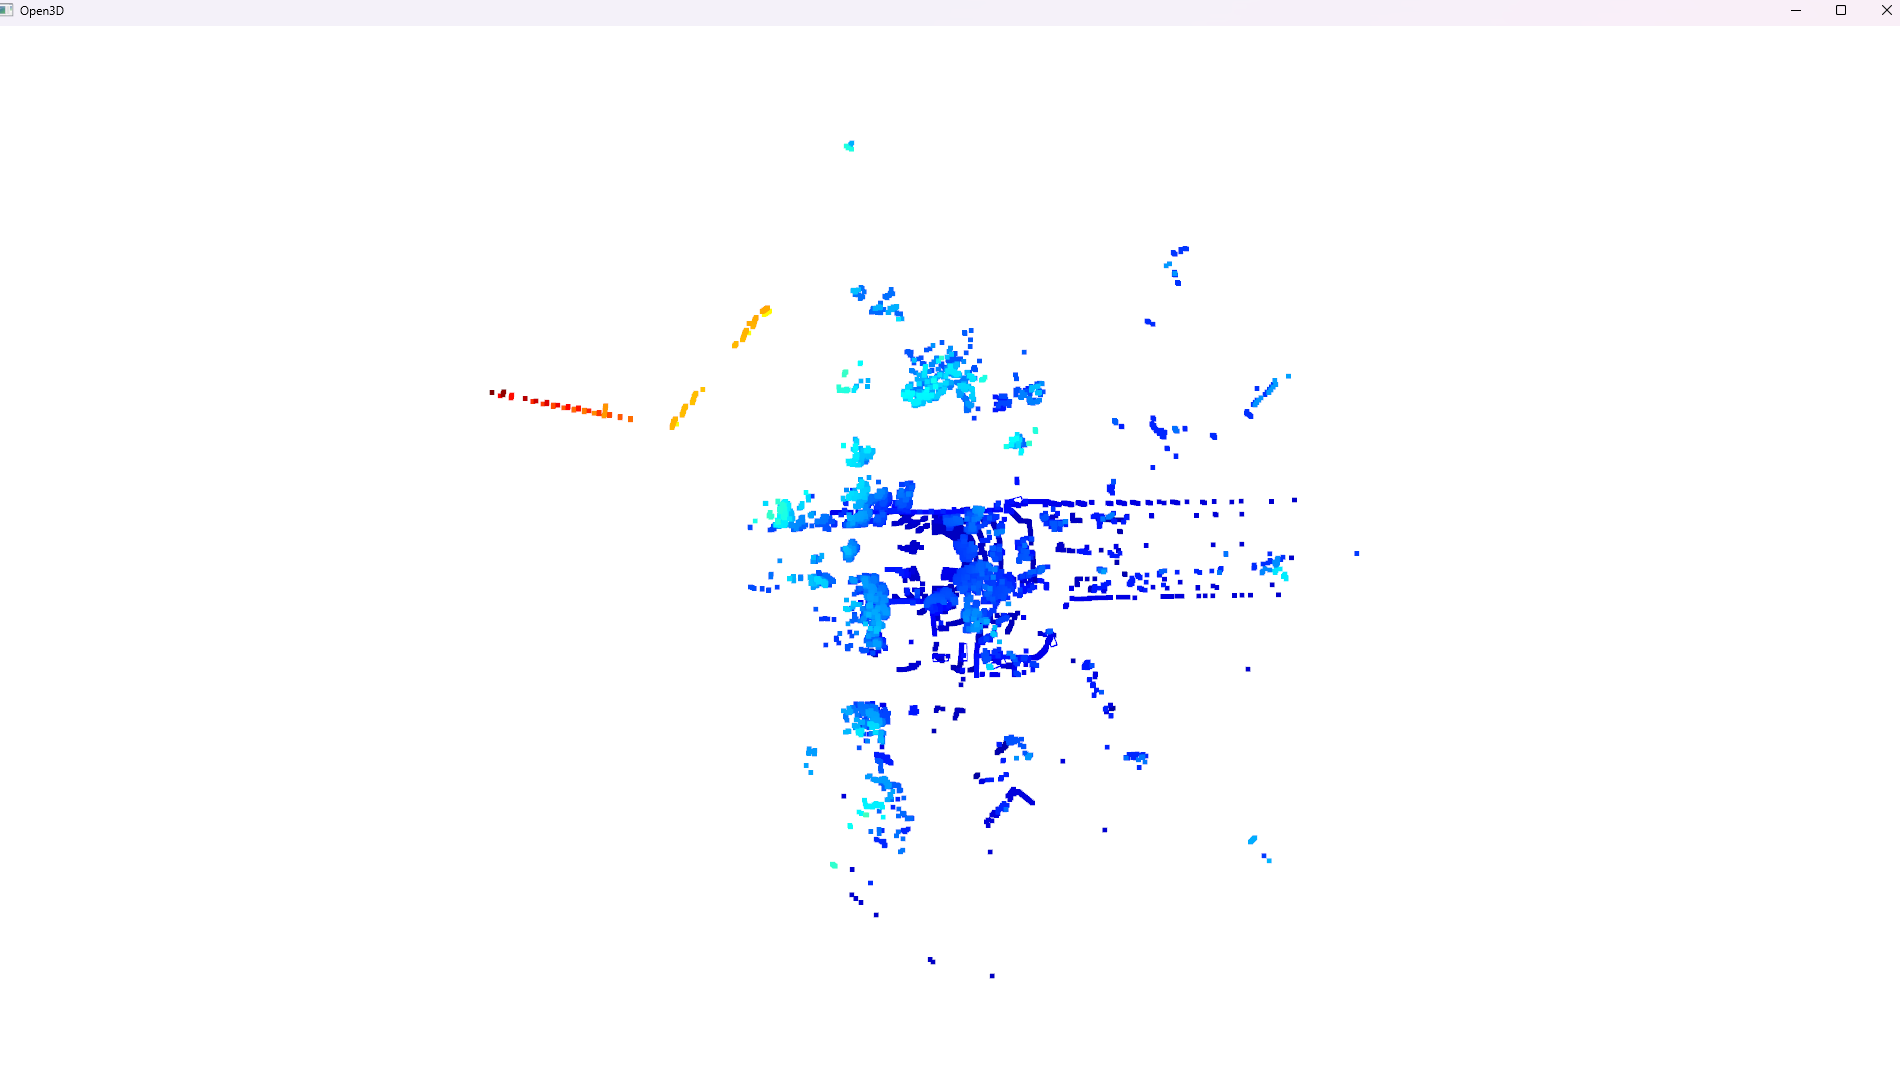
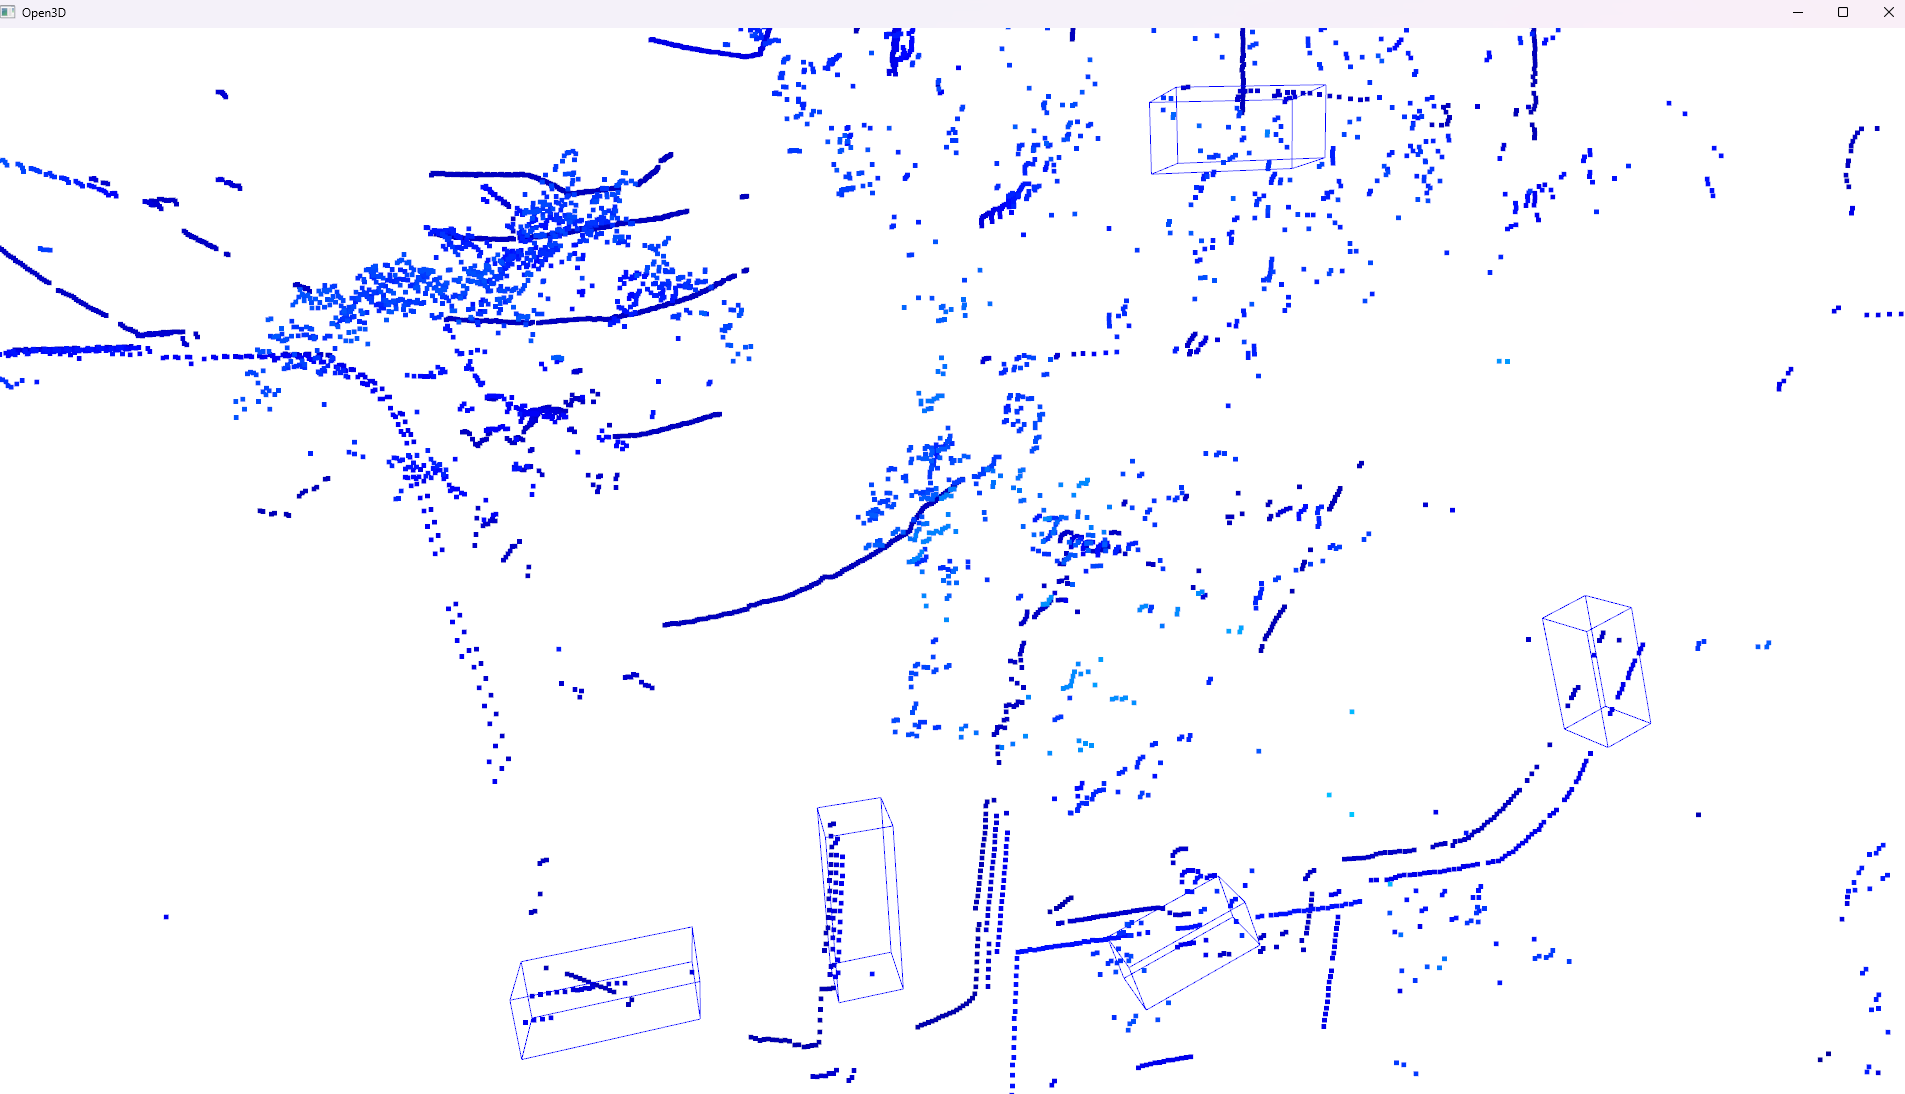
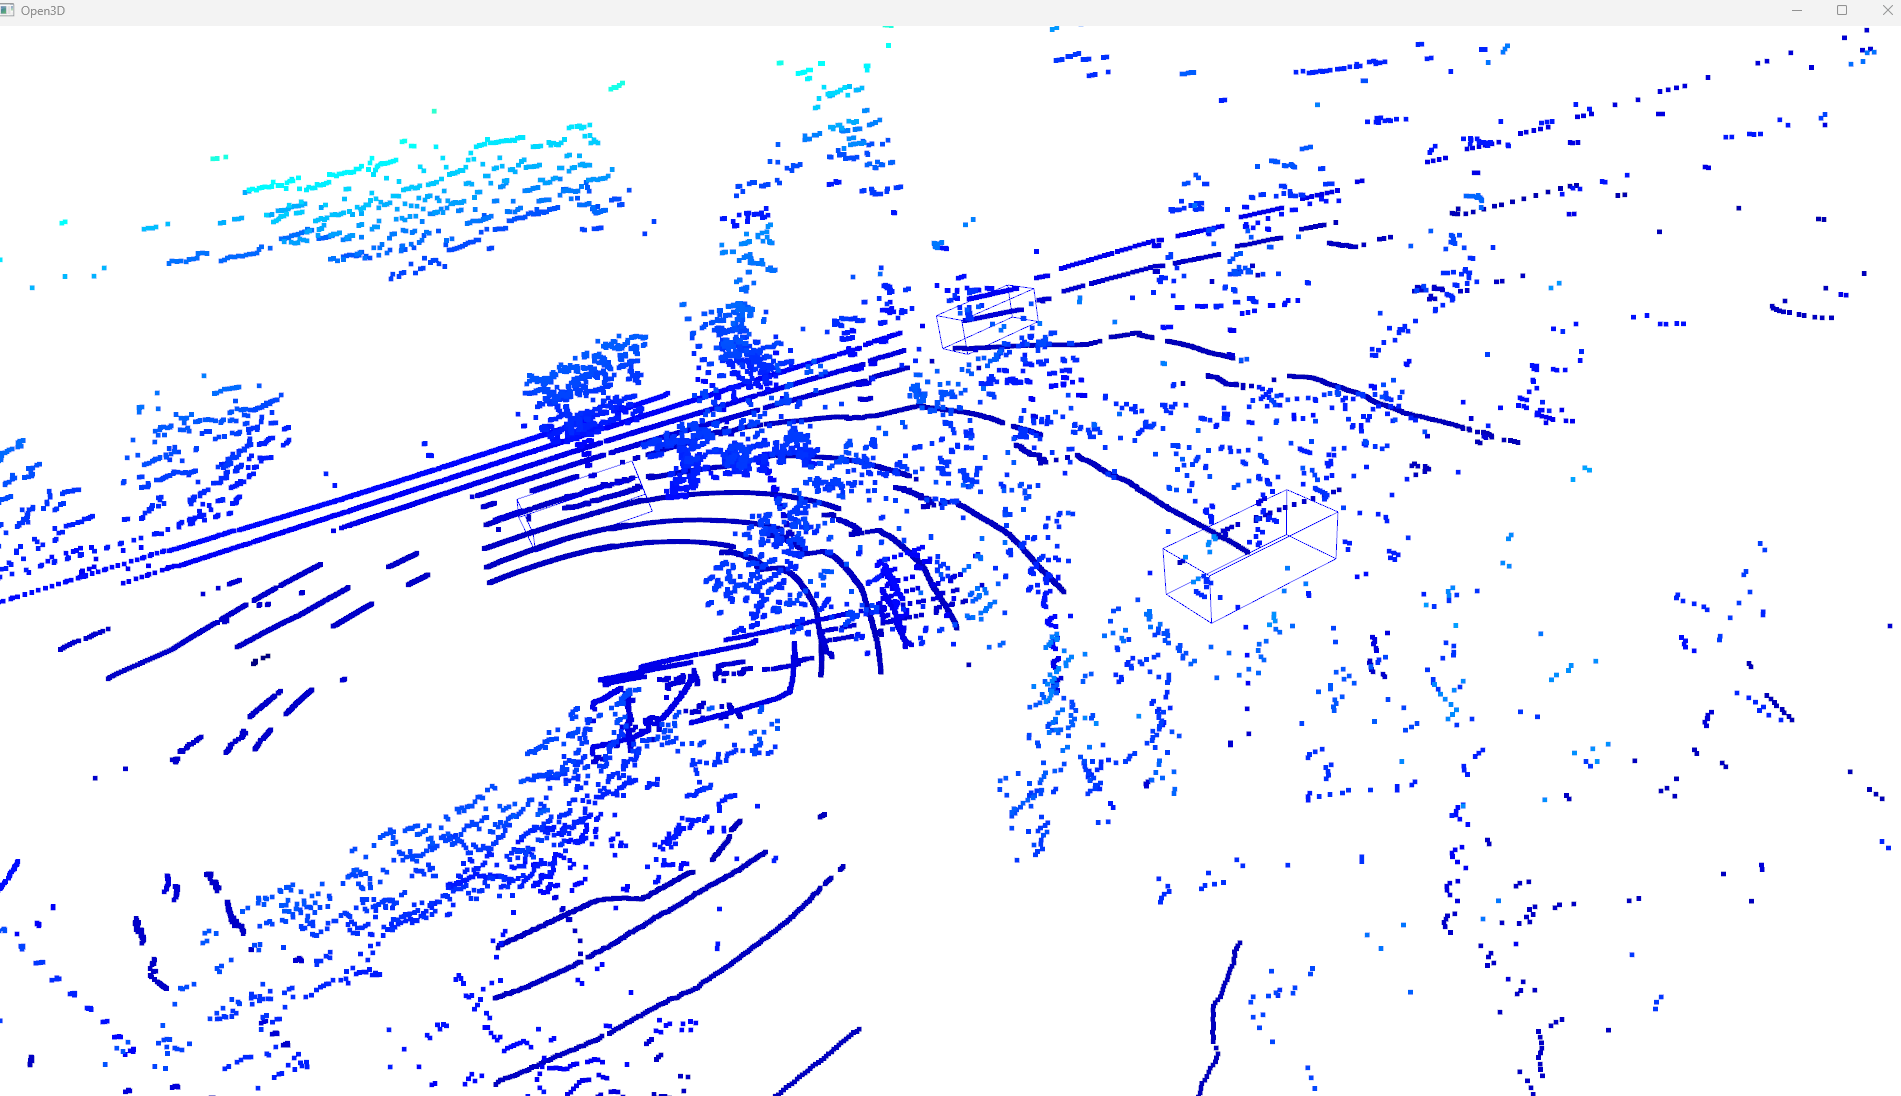
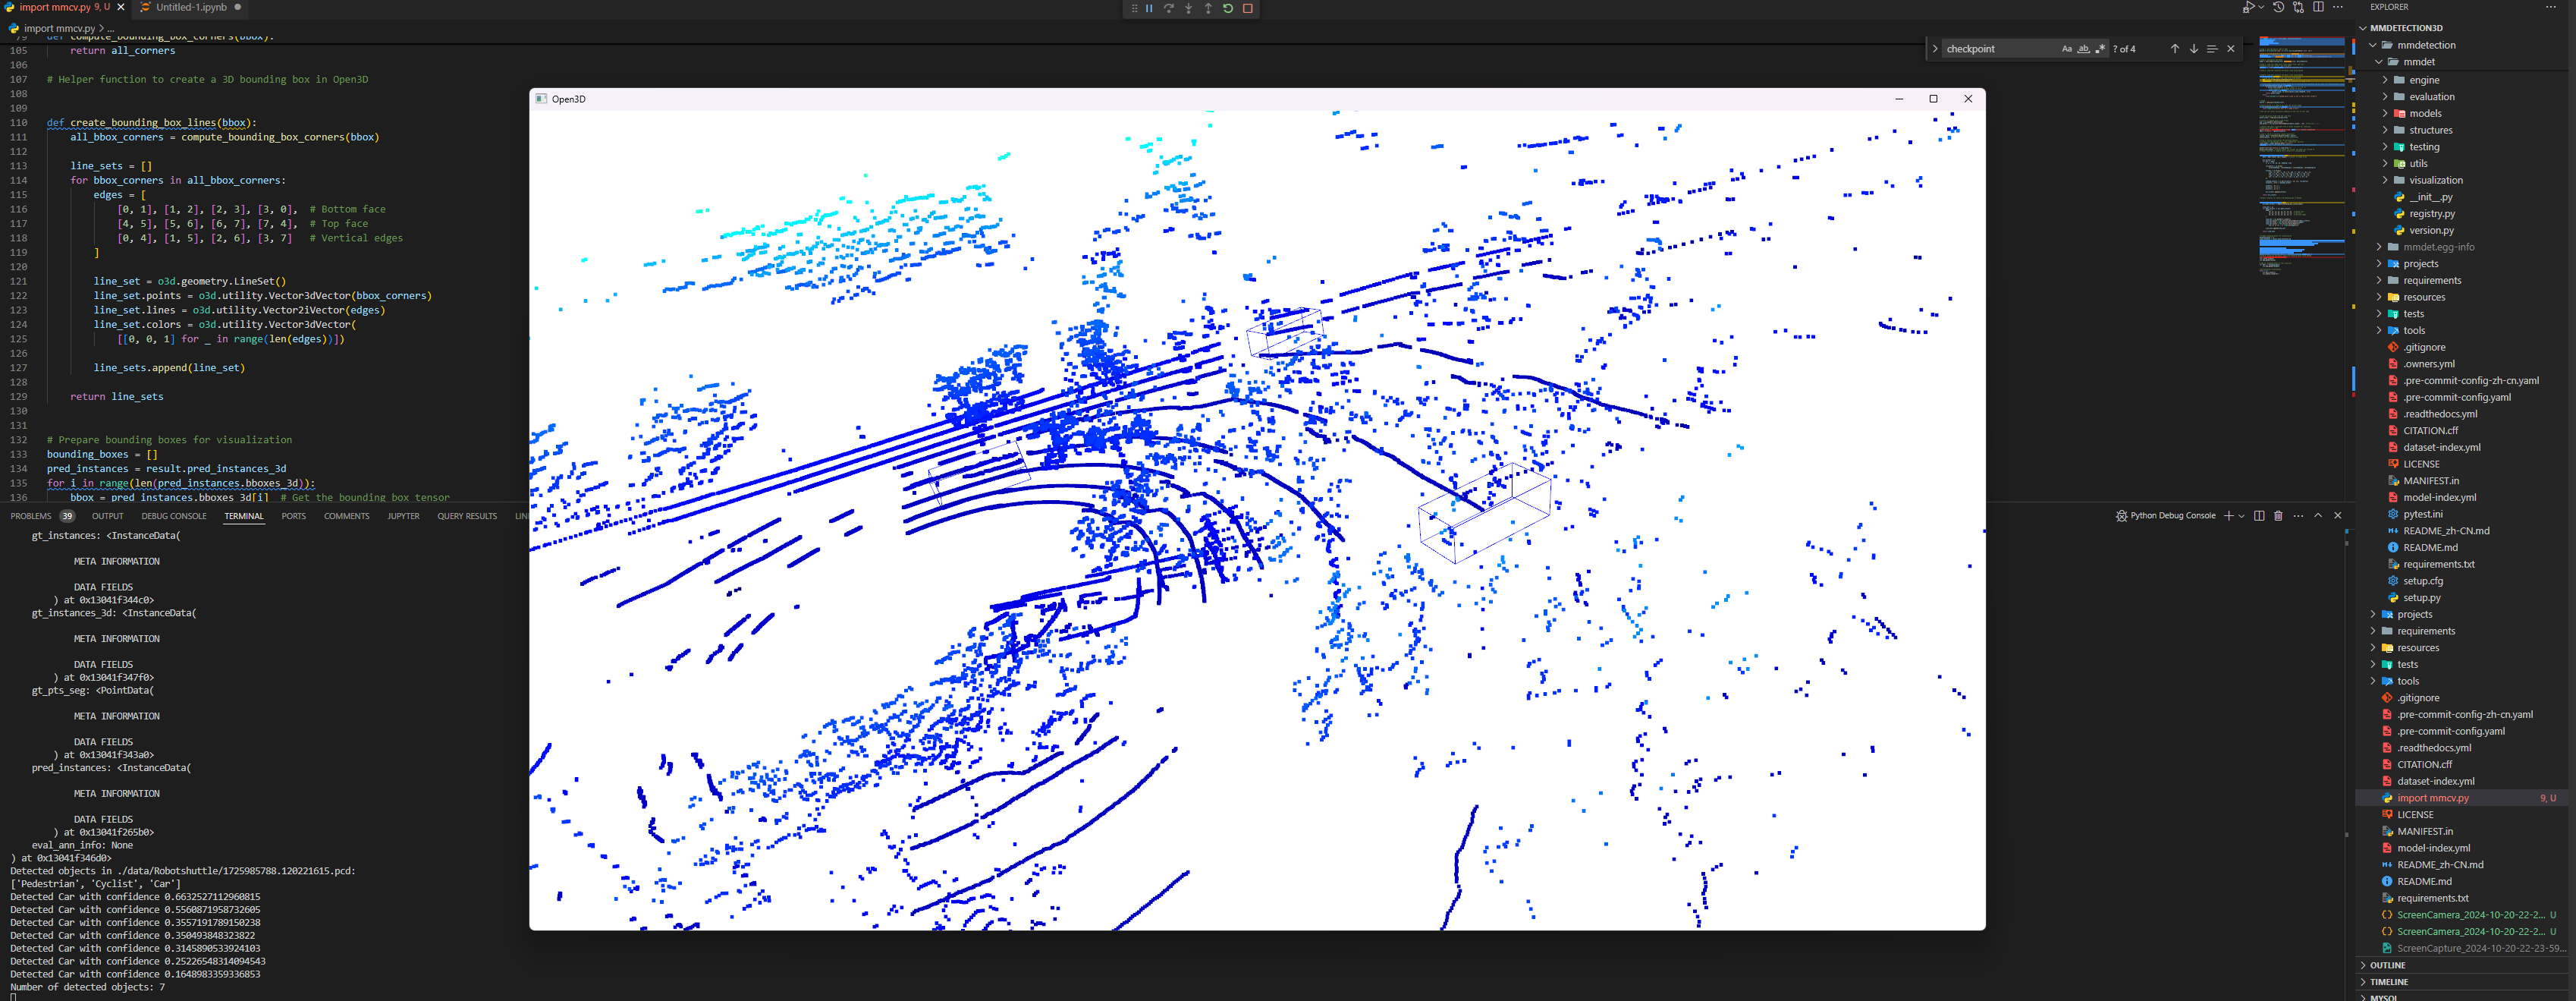

Segundo pcd 1725985647.014677048.pcd

Resultados:
['Pedestrian', 'Cyclist', 'Car']
Detected Car with confidence 0.9118364453315735
Detected Car with confidence 0.4647652804851532
Detected Car with confidence 0.3537457585334778
Detected Car with confidence 0.26094621419906616
Detected Car with confidence 0.20432458817958832
Detected Car with confidence 0.18055127561092377
Detected Car with confidence 0.1198047548532486
Detected Car with confidence 0.11443519592285156
Detected Car with confidence 0.1135660707950592
Number of detected objects: 9


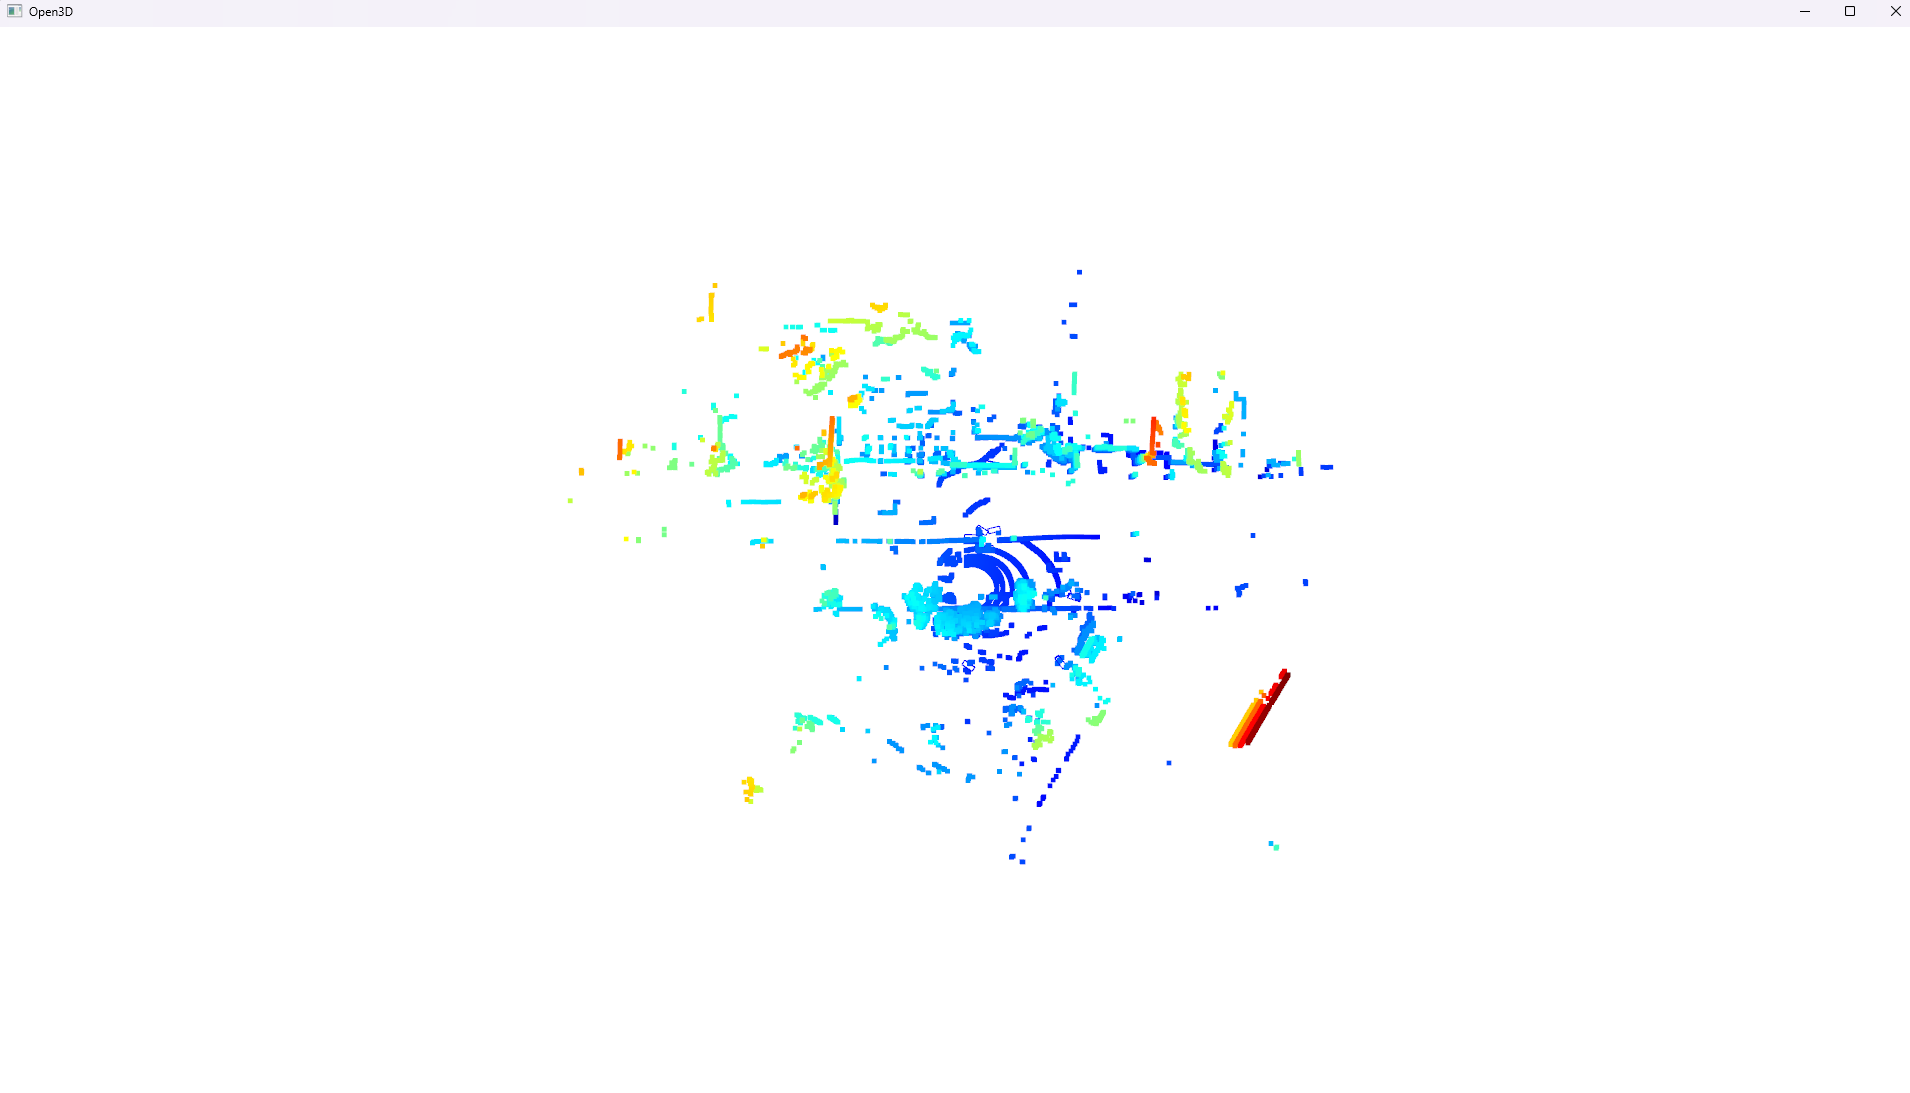
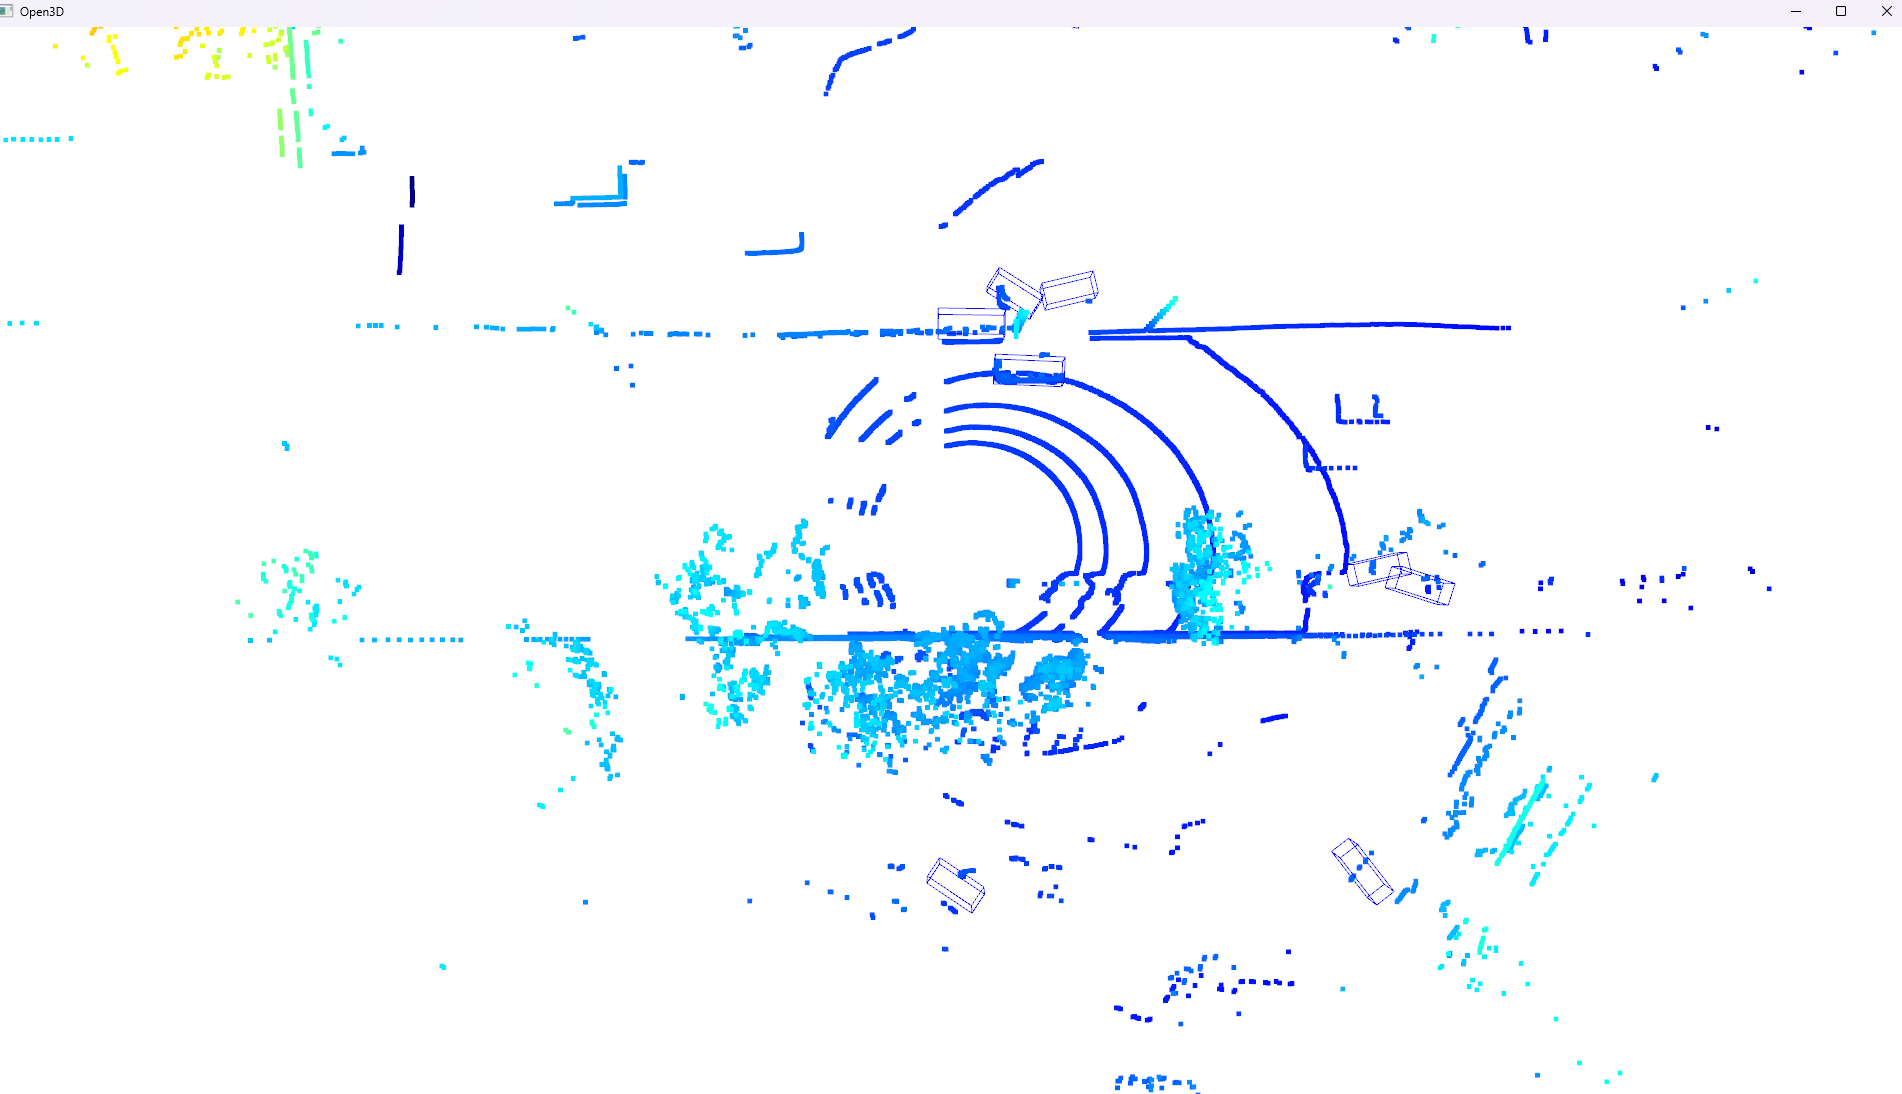
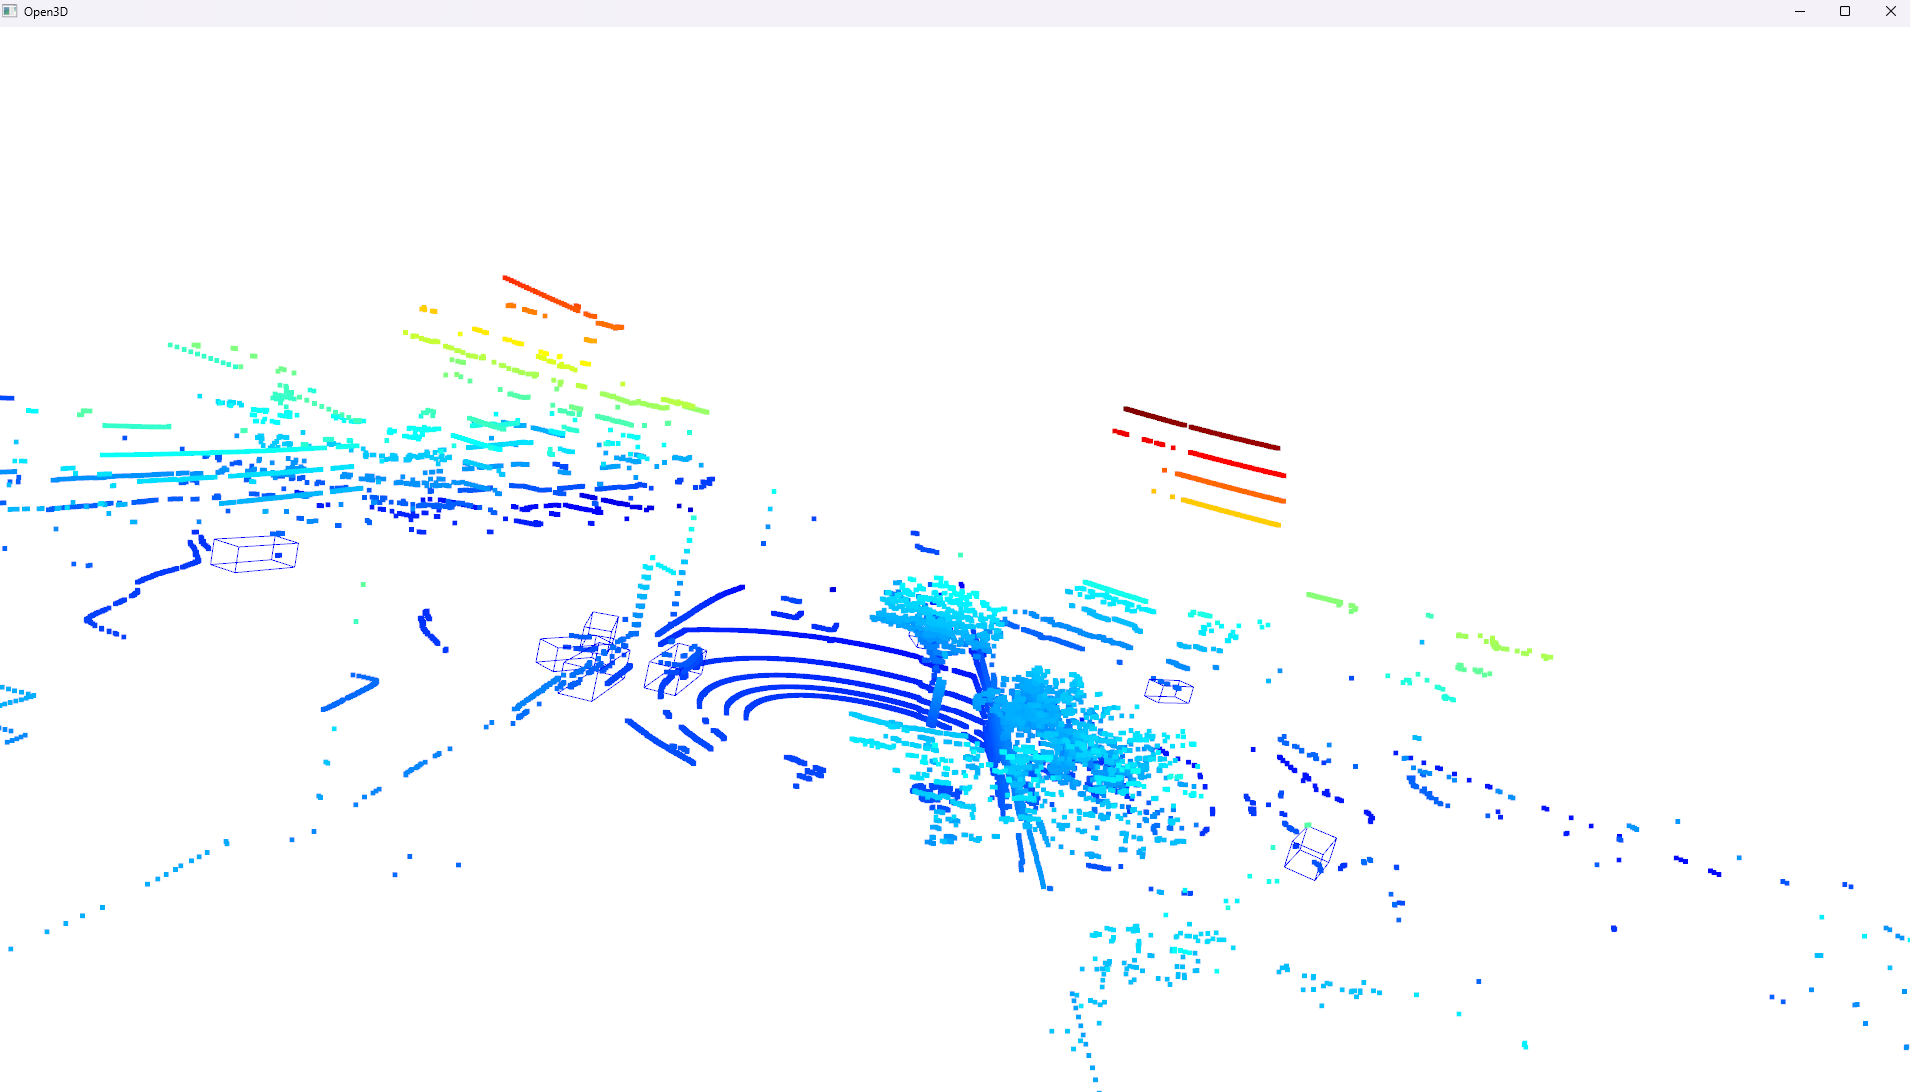

Tercer pcd 1725985718.626486063.pcd

Resultados:
['Pedestrian', 'Cyclist', 'Car']
Detected Car with confidence 0.9310964345932007
Detected Car with confidence 0.8481061458587646
Detected Car with confidence 0.5610576272010803
Detected Car with confidence 0.5468651652336121
Detected Car with confidence 0.5383334755897522
Detected Car with confidence 0.4388965964317322
Detected Car with confidence 0.10205955803394318
Number of detected objects: 7

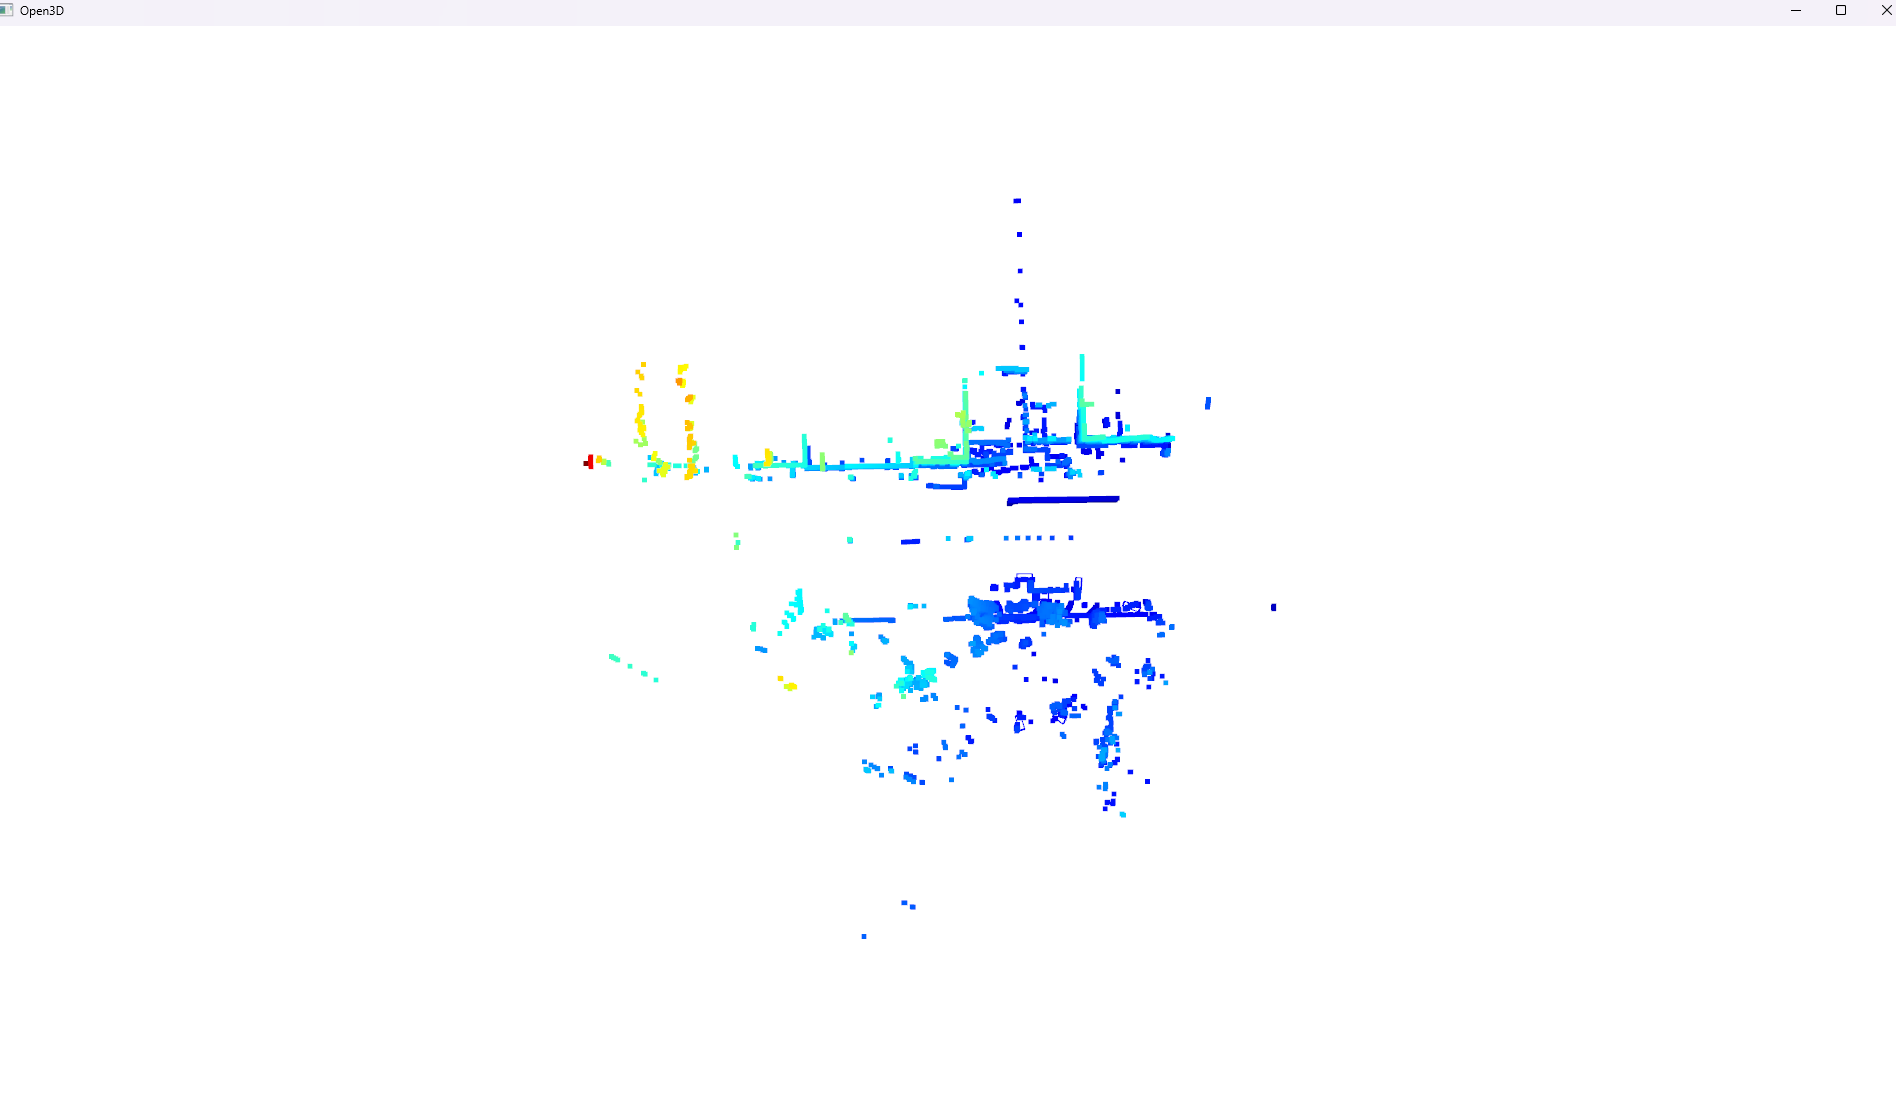
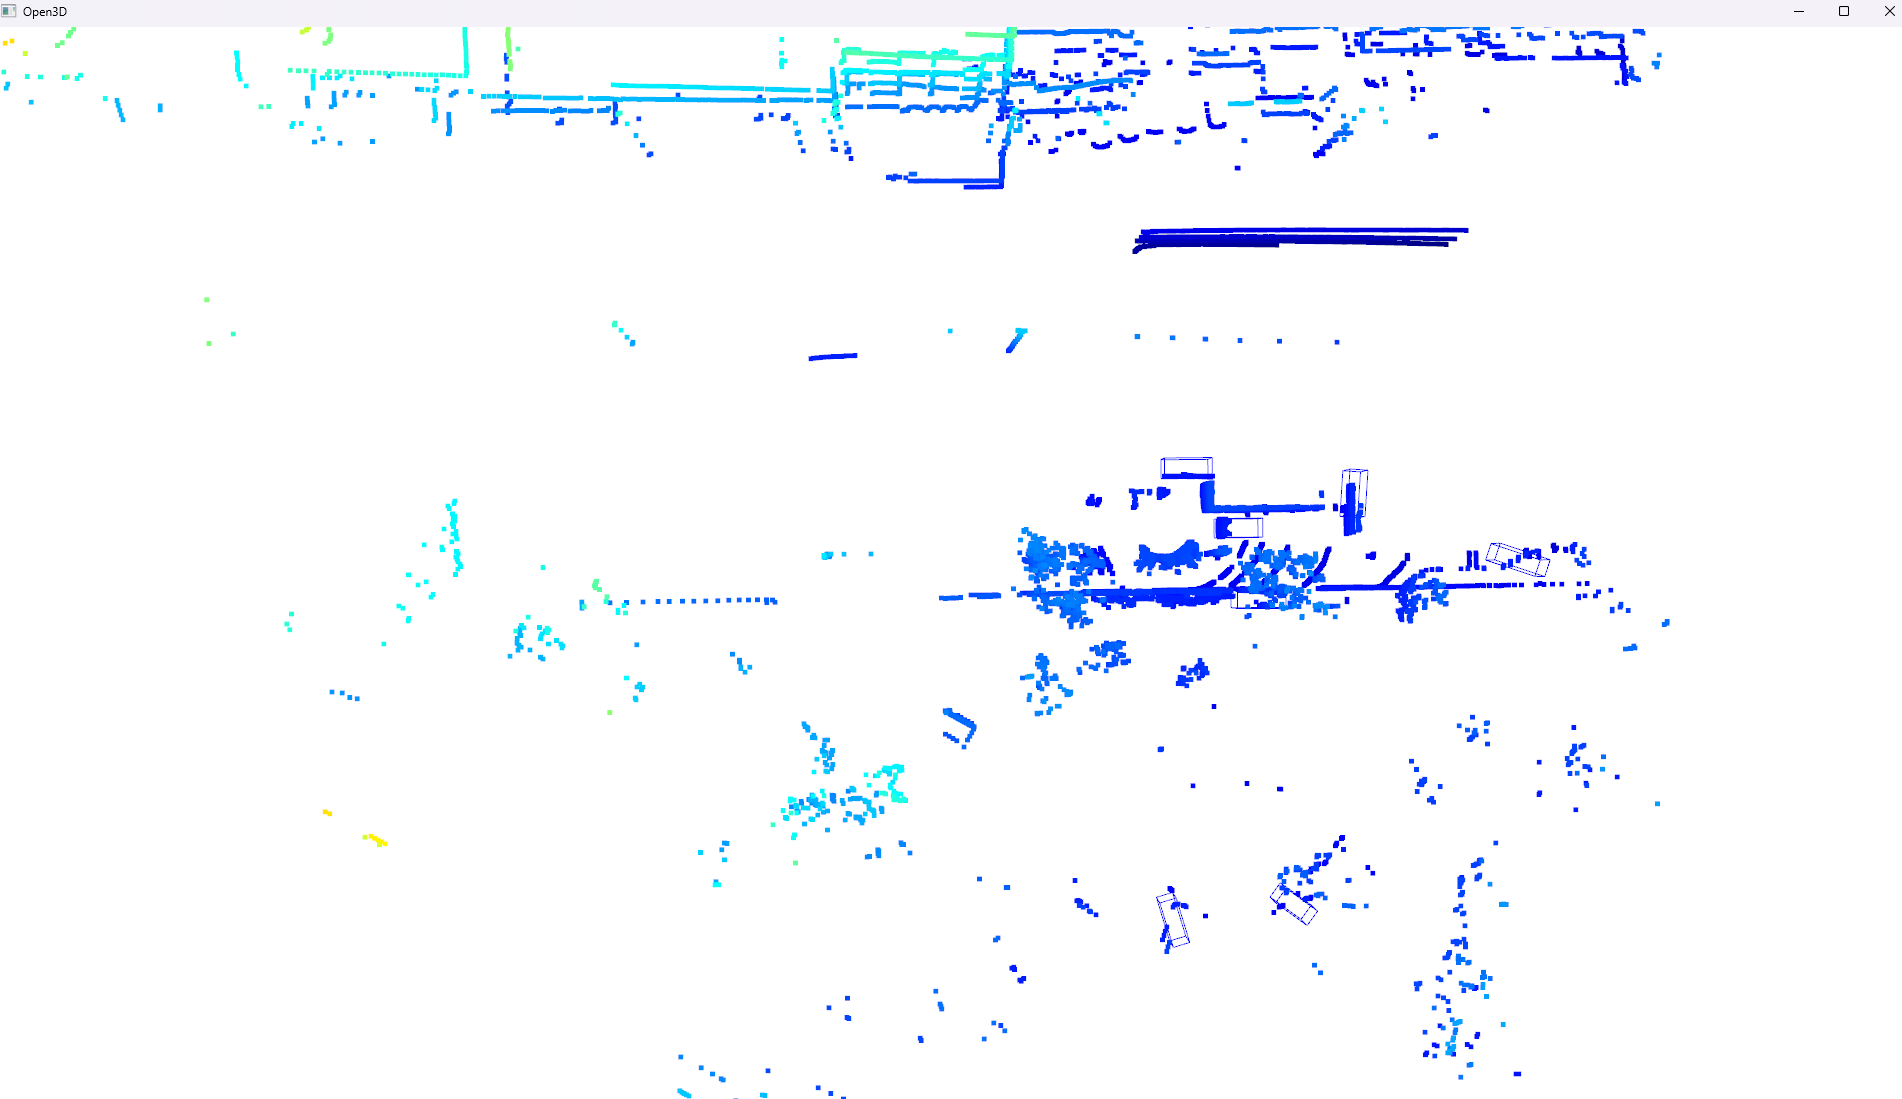
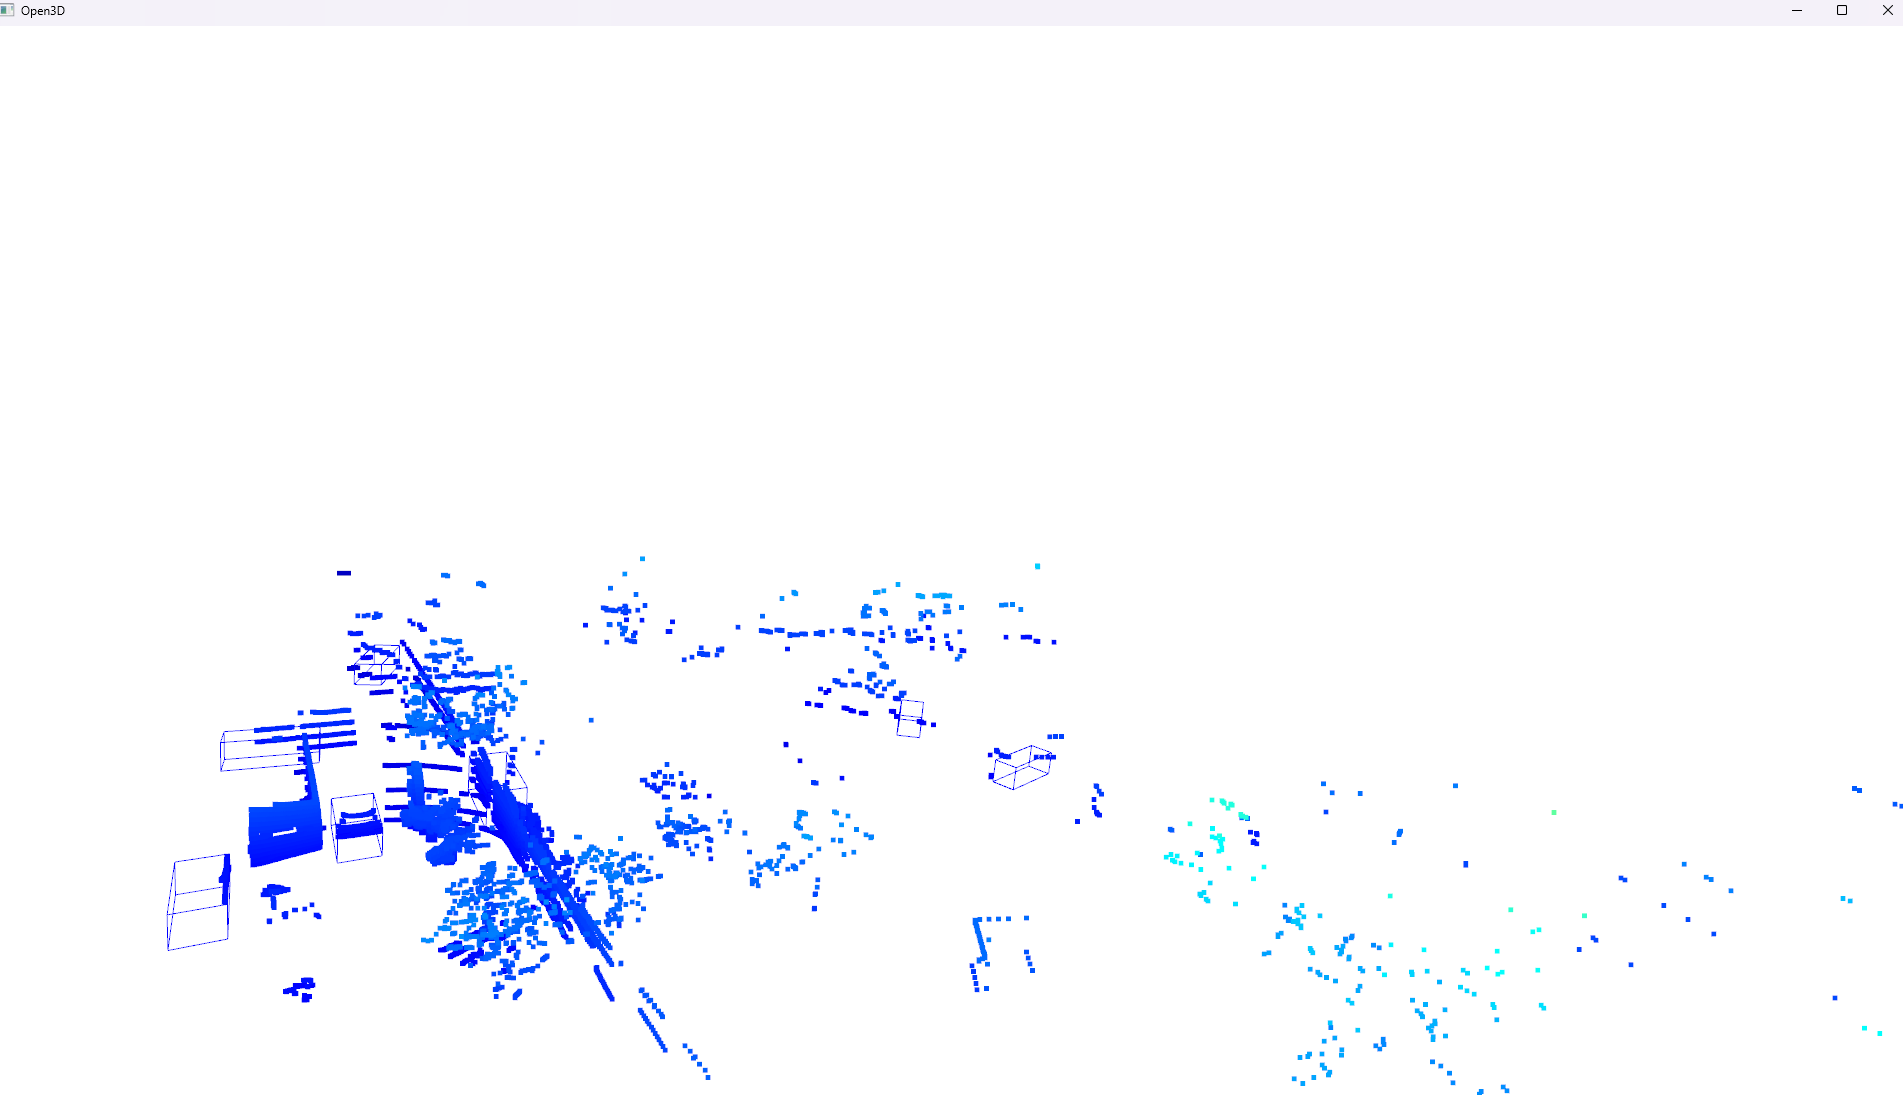
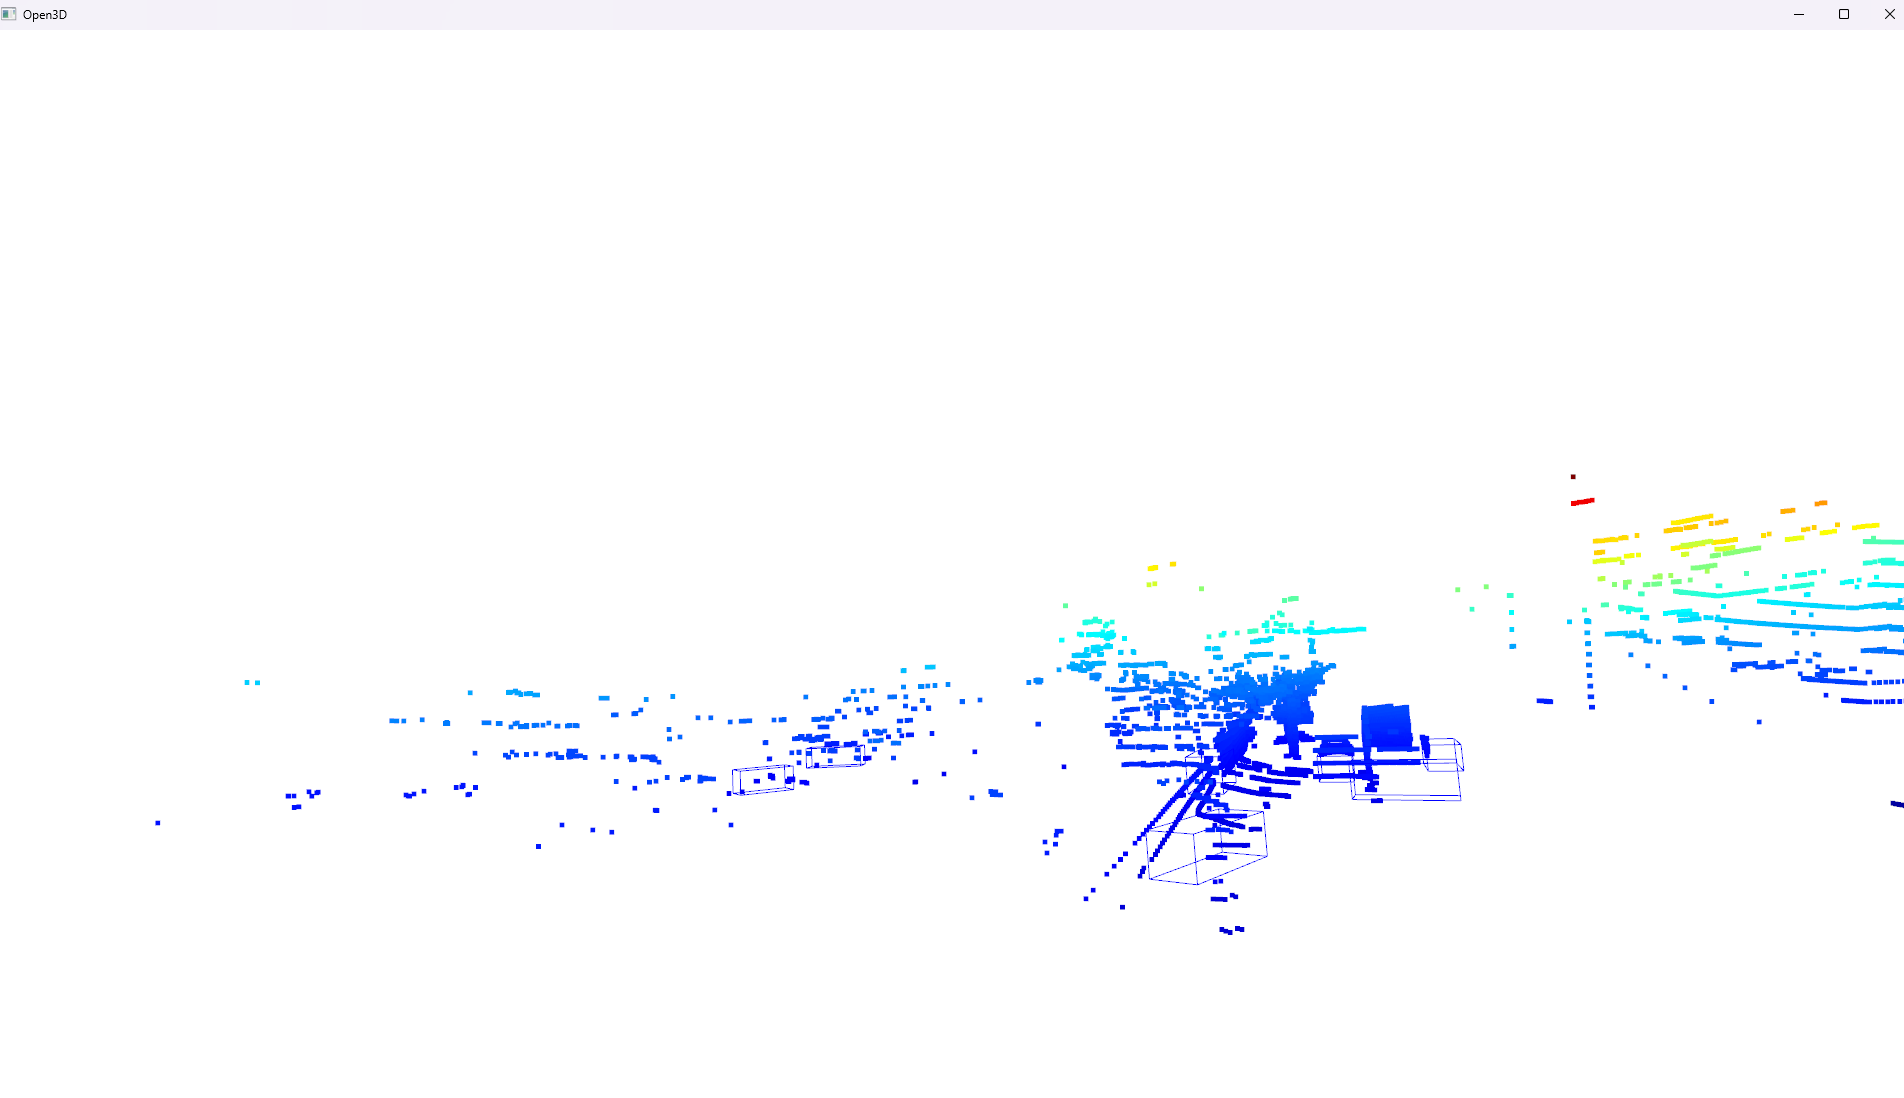

Conclusiones:

La tecnología PV-RCNN se fundamenta en dos módulos fundamentales:

1. Código de escena voxel-a-punto esencial: Esta fase disminuye la cantidad de cálculos y almacena información esencial de la escena mediante la elección de un conjunto limitado de puntos clave.

2. Abstracción de características RoI (Región de Interés): Mediante la utilización de múltiples campos receptivos, se extraen características de contexto más enriquecidas con el objetivo de optimizar la predicción de las cajas delimitadoras y aumentar la fiabilidad de las detecciones.

Beneficios:

1. Optimización de la integración de atributos: Incorpora metodologías fundamentadas en vóxeles y puntos para adquirir características de mayor discriminación.

2. Eficiencia: La red de comunicación neuronal de vóxeles facilita la generación de propuestas de alta calidad con un costo computacional reducido.

3. Optimización de la precisión: La abstracción de atributos mediante el uso de puntos clave y rejillas RoI facilita un refinamiento más efectivo de las cajas de detección de objetos.

4. Resultados sobresalientes: Superan a los métodos previos en conjuntos de datos críticos como KITTI y Waymo, logrando la posición de liderazgo en determinados benchmarks.

Inconvenientes:

1. Aplicación intensiva de memoria: Pese a los intentos de disminuir el número de cálculos, el algoritmo continúa siendo oneroso en términos de gasto de memoria.

2. Dependencia de hardware: La implementación del modelo demanda un hardware robusto, tal como múltiples Unidades de Procesamiento Gráfico (GPUs), lo que podría constituir un obstáculo para implementaciones de menor peso.

En términos generales, la solución PV-RCNN representa una solución robusta para la detección 3D en nubes de puntos, particularmente en aplicaciones como la conducción autónoma.
